**Event Extraction with Reinforcement Learning**

- This part of event extraction process uses Reinforcement Learning. 
- The process comprises of a main-task and a subsidiary-task.


*Main-Task: Trigger Identification*
- The main-task is also referred as trigger identification. In this task, the Agent sequentially scans tokens in the input sentence. 
- At each time step, the event type is assigned to the corresponding token according to a stochastic policy in RL.
- If the current word is recognized as an event trigger, a subsidiary-task will be launched.
- If the current word has an event type of 'None', the agent will skip the argument detection sub-task.

*Subsidiary-Task: Argument Detection*
- When a token is marked as event trigger, a subsidiary task is launched.
- This task detects the arguments in the event that corresponds to the event trigger. 
- The performance of this subtask is used to compute the reward for the action taken in the main-task.

**Extraction Process Steps**

The entire process is depicted in the following diagram and explained in steps: 

> ![BMEE](BMEE.png "Biomedical Event Extraction")
> * Current token in sentence is identified as event trigger 
> * The vector of trigger word and the embedded environment information will be concatenated and fed to Agent
> * The Agent takens an action, representing the predicted event type for word, according to a stochastic policy.
> * The word embedding is then concatenated with action vector to create a new representation, for all words in the input sentence.
> * This new representation of the input sentence pass through a BiLSTM-CRF module which detects the arguments given the indentified event trigger.
> * Then the predicted result of argument detection Y' is compared with ground-truth Y to compute a Reward.
> * Additionally, Y' is transformed into a vector L by a BiLSTM layer which is concatenated to environment information. This ends up helping the subsequent trigger. 

**Trigger Identification**

- Trigger identification is the main task in the Reinforcement Learning part of the implementation
- This Module will read the sentences in the text, break a sentence into tokens, use the embedding generated by the KB Augmented Representation module to detect if a given token in a sentence is a trigger or not. 
- The set of possible actions include all identified event types and an additional 'None' type if a token is non-trigger.
- We will be utilizing a few classes that will read and parse the input data, and prepare the text data and provided annotations for RL environment.


In [1]:
# !pip install sentence-transformers
# !pip install scikit-learn
# !pip install keras

In [2]:
from itertools import chain

import pickle
import time
import numpy as np

import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import StanfordPOSTagger
#nltk.download('punkt')

from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
import sqlite3

import os
import numpy as np
import itertools

import random

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

from tqdm import tqdm
from matplotlib import pyplot as plt

2023-12-07 22:47:09.043600: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


**Embeddings for tokens**

- The following few steps, we have a bunch of classes together that will provide an embedding for each token in the sentence.
- These include GloVe word embedding [100], Parts-of-Speech tag embedding, Entity Type embedding, and KBs concept embedding, in order. 
- All of these embeddings are concatenated PER TOKEN in the sentence.



In [3]:
class GloVeWordEmbedder:
    def __init__(self, pathGloveFile):
        self.pathGloveFile = pathGloveFile
        self.wordToVectorMap = {}
        self.loadAndParseGloVeData()
    
    def loadAndParseGloVeData(self):
        print("Creating wordToVectorMap for GloVe data:")
        startTime = time.time()
        with open(self.pathGloveFile, 'r', encoding="utf-8") as file:
            for line in file:
                values = line.strip().split()
                word = values[0]
                vector = np.asarray(values[1:], "float32")
                self.wordToVectorMap[word] = vector
        print("Done - Creating wordToVectorMap for GloVe data")
        endTime = time.time()
        loadTime = endTime - startTime
        print(f"Took {loadTime} seconds to read GloVe data")
    
    def getWordEmbedding(self, word):
        return self.wordToVectorMap.get(word.lower(), np.zeros(100))

In [4]:
class POSTagEmbedder:
    
    def __init__(self, pathPOSmodel, pathJPOSar, dimension=50):
        print("Initializing Parts-of-Speech Tagger")
        self.tagger = StanfordPOSTagger(pathPOSmodel, pathJPOSar, encoding='utf-8')
        self.dimension = dimension
        self.posEmbeddings = {}
        print("Initialized Parts-of-Speech Tagger")
    
    def tagSentence(self, sentence):
        tokens = word_tokenize(sentence)
        return self.tagger.tag(tokens)
    
    def getEmbedding(self, pos_tag):
        if pos_tag not in self.posEmbeddings:
            self.posEmbeddings[pos_tag] = np.random.rand(self.dimension)
        return self.posEmbeddings[pos_tag]
    
    def embedSentence(self, sentence):
        posTags = self.tagSentence(sentence)
        posTagEmbeddings = [self.getEmbedding(tag) for _,tag in posTags]
        return posTags, posTagEmbeddings

In [5]:
class EntityTypeEmbedderSTANDOFF:
    
    def __init__(self, inputDir, embeddingDim=50):
        self.embeddingDim = embeddingDim
        self.entityEmbeddings = {}
        self.tokenEntityMappings = {}
        self.entityTypes = set()
        self.inputDir = inputDir
        self.extractTokenEntityMapping()
    
    def extractTokenEntityMapping(self):
        numFiles = 0
        for dirpath, _, filenames in os.walk(self.inputDir):
            for filename in filenames:
                if filename.endswith(".ann"):
                    numFiles += 1
                    filePath = os.path.join(dirpath, filename)
                    with open(filePath, 'r', encoding='utf-8') as file:
                        for line in file:
                            if line.strip():  # non-empty line
                                parts = line.split("\t")
                                if len(parts) == 3 and parts[0][0] == "T":
                                    token, entityTypeParts = parts[-1].strip(), parts[1]
                                    middleParts = entityTypeParts.split()
                                    entityType = middleParts[0]
                                    self.tokenEntityMappings[token] = entityType
                                    if entityType not in self.entityEmbeddings:
                                        self.entityTypes.add(entityType)
                                        self.entityEmbeddings[entityType] = np.random.rand(self.embeddingDim)
        print(f"Processed {numFiles} .ann files.")
        uniqueTokens = len(self.tokenEntityMappings)
        uniqueEntities = len(self.entityTypes)
        print(f"Found {uniqueTokens} unique tokens which correspond to entities")
        print(f"Found {uniqueEntities} unique entities")

    def get_embedding(self, token):
        entityType = self.get_entity_type(token)
        return self.entityEmbeddings.get(entityType, np.zeros(self.embeddingDim))
    
    def get_entity_type(self, token):
        return self.tokenEntityMappings.get(token, 'None')
    
    def update_embedding(self, entityType, newEmbedding):
        if entityType in self.entityEmbeddings:
            self.entityEmbeddings[entityType] = newEmbedding
        else:
            raise ValueError(f"Entity type {entityType} not in embeddings dictionary")

In [6]:
class OntologyDefinitionEmbedder:
    
    def __init__(self, sqlitePath, table,pcaComponents=100, sentenceTransformerType="all-MiniLM-L6-v2"):
        self.entityGOdefinitionEmbedding = {}
        self.sqliteConn = sqlite3.connect(sqlitePath)
        self.table = table
        self.pcaComponents = pcaComponents
        self.sentenceTransformerType = sentenceTransformerType
        
    def readSQLiteData(self):
        
        print("Reading GO definitions from SQLite")
        cursor = self.sqliteConn.cursor()
        
        query = """
        SELECT entity, GO_definition
        FROM {table}
        WHERE GO_definition != '' AND GO_definition IS NOT NULL;
        """.format(table=self.table)
        
        cursor.execute(query)
        self.rows = cursor.fetchall()
        self.sqliteConn.close()
        
        print(f"Done Reading {len(self.rows)} GO definitions from SQLite")
        
        
    def createEmbeddings(self):
        print("Creating embeddings for GO_definitions")
        model = SentenceTransformer(self.sentenceTransformerType)
        pca = PCA(n_components=self.pcaComponents)
        
        entities = []
        GOdefs = []
        
        for row in self.rows:
            entities.append(row[0])
            GOdefs.append(row[1])
        
        definitionEmbeddings = model.encode(GOdefs)
        reducedEmbeddings = pca.fit_transform(definitionEmbeddings)
        
        self.entityGOdefinitionEmbedding = dict(zip(entities, reducedEmbeddings))
        print(f"Done Creating embeddings for {len(entities)} GO_definitions corresponding to entities")
        
    def getEmbeddingForEntity(self, entity):
        return self.entityGOdefinitionEmbedding.get(entity, np.zeros(self.pcaComponents))

In [7]:
class KBAugmentedWordRepresentation:
    def __init__(self):
        
        self.pathGloVe100dFile = '../BME Corpora/glove.6B/glove.6B.100d.txt'
        
        self.pathToPOSJar = "../stanford-postagger-full-2020-11-17/stanford-postagger.jar"
        self.pathToPOSModel = "../stanford-postagger-full-2020-11-17/models/english-bidirectional-distsim.tagger"
        
        self.entityTypeInputDir = '../BME Corpora/MLEE-1.0.2-rev1/standoff/full/'
        
        self.sqlitePath = "../QuickGO.db"
        self.standOffTable = "QuickGOSTANDOFF"
        
        self.initGloveEmbedder()
        self.initEntityTypeEmbedder()
        self.initPosTagEmbedder()
    
    def initGloveEmbedder(self):
        self.gloVeEmbedder = GloVeWordEmbedder(self.pathGloVe100dFile)
        
    def initPosTagEmbedder(self):
        self.posTagEmbedder = POSTagEmbedder(self.pathToPOSModel, self.pathToPOSJar)
    
    # this embedding module works in isolation - However, it ends up killing the kernel while integrating in the pipeline
    def initKBConceptEmbedder(self):
        self.kbConceptEmbedder = OntologyDefinitionEmbedder(self.sqlitePath, self.standOffTable)
        self.kbConceptEmbedder.readSQLiteData()
        self.kbConceptEmbedder.createEmbeddings()
    
    def initEntityTypeEmbedder(self):
        self.entityTypeEmbedder = EntityTypeEmbedderSTANDOFF(self.entityTypeInputDir)
    
    def getKBRepresentationForToken(self, token):
        reprGlove = self.gloVeEmbedder.getWordEmbedding(token)
        reprEntityType = self.entityTypeEmbedder.get_embedding(token)
        return np.concatenate((reprGlove, reprEntityType))
    
    def getPosTagForSentence(self, text):
        return self.posTagEmbedder.embedSentence(text)

In [8]:
class AnnotationReader:
    def __init__(self):
        pass
    
    def readAnnotations(self, filePath):
        with open(filePath, 'r', encoding='utf-8') as file:
            return file.read()
    
    def parseAnnotations(self, content):
        entities = {}
        events = {}
        
        for line in content.strip().split('\n'):
            if line.startswith('T'):
                parts = line.split('\t')
                if len(parts) != 3:
                    continue;
                entityId, entityInfo, _ = parts
                entityType, start, end = entityInfo.split(' ')
                entities[entityId] = {'type': entityType, 'span': (int(start), int(end))}
            elif line.startswith('E'):
                parts = line.split('\t')
                eventId, eventInfo = parts
                eventInfoParts = eventInfo.split(' ')
                if len(eventInfoParts) != 3:
                    continue
                eventTypeTrigger = eventInfoParts[0].split(':')
                eventArgs = [arg.split(':') for arg in eventInfoParts[1:]]
                events[eventId] = {'type': eventTypeTrigger[0], 'trigger': eventTypeTrigger[1], 'args': eventArgs}
        return entities, events

In [9]:
class StateRepresentation:
    def __init__(self, kbEmbedder, tokens):
        self.kbEmbedder = kbEmbedder
        self.tokens = tokens
    
    def getEmbedding(self, token):
        return self.kbEmbedder.getKBRepresentationForToken(token)
    
    def getState(self, currentIndex):
        currentToken = self.tokens[currentIndex]
        state = self.getEmbedding(currentToken)
        return state

In [10]:
class RLAgent:
    def __init__(self, stateSize=150, actionSize=2, hiddenSize=32, learningRate=0.001):
        self.stateSize = stateSize
        self.actionSize = actionSize
        
        # Build MLP for trigger identification
        self.model = Sequential()
        self.model.add(Dense(hiddenSize, input_dim=stateSize, activation='relu'))
        self.model.add(Dense(actionSize, activation='softmax'))
        
        self.model.compile(loss='categorical_crossentropy', optimizer=Adam(learningRate))
        
    def chooseAction(self, state):
        # Revise: action should be based on policy
        # Trigger: 1, Not Trigger 0
        state = np.reshape(state, [1, self.stateSize])
        actionProbability = self.model.predict(state, verbose=0)[0]
        action = np.random.choice(range(self.actionSize), p=actionProbability)
        return action
    
    def learn(self, state, action, reward, nextState, done):
        state = np.reshape(state, [1, self.stateSize])
        if nextState is not None:
            nextState = np.reshape(nextState, [1, self.stateSize])
        else:
            nextState = np.zeros([1, self.stateSize])
            
        # Predicted Q-values for the current state
        currentQ = self.model.predict(state, verbose=0)[0]
        
        # Update Q-value for the action taken
        currentQ[action] = reward
        
        self.model.fit(state, np.array([currentQ]), verbose=0)

In [11]:
class RLEnvironment:
    def __init__(self, kbEmbedder, annotationReader):
        self.directoryPath = "../BME Corpora/MLEE-1.0.2-rev1/standoff/full/"
        self.kbEmbedder = kbEmbedder
        self.annotationReader = annotationReader
        
        self.fileNames = self.fileList(".ann") # or could use .txt since they are in pairs
        print(f"Number of files to read:{len(self.fileNames)}")
        
        self.fileIndex = 0
        self.tokenIndex = 0
        self.text = ""
        
        self.entities = None
        self.events = None
        
        self.stateRepr = None
        
        self.totalIdAttempts = 0
        self.triggersIdentified = 0
        self.nontriggersIdentified = 0
        self.misclassified = 0
        
    def fileList(self, extension):
        try:
            fileNames = os.listdir(self.directoryPath)
            files = [os.path.splitext(file)[0] for file in fileNames if file.endswith(extension)]
            return files
        except Exception as e:
            return f"Error occurred while reading file names"
        
    def loadNextFile(self):
        baseFileName = self.fileNames[self.fileIndex]
        txtPath = os.path.join(self.directoryPath, baseFileName+'.txt')
        annPath = os.path.join(self.directoryPath, baseFileName+'.ann')
        
        with open(txtPath, 'r') as txtFile:
            self.text = txtFile.read()
        
        self.currentFileTokens = self.text.split() # simple tokenization
        self.totalTokens = len(self.currentFileTokens)
        
        self.stateRepr = StateRepresentation(self.kbEmbedder, self.currentFileTokens)
        self.entities, self.events = self.loadAnnotations(annPath)
        self.tokenIndex = 0
    
    def loadAnnotations(self, annPath):
        annFileContent = self.annotationReader.readAnnotations(annPath)
        entities, events = self.annotationReader.parseAnnotations(annFileContent)
        return entities, events
        
    def reset(self):
        # new text
        if self.fileIndex >= len(self.fileNames):
            print(f"All files were look at - going Round-Robin")
            self.fileIndex = 0 # reset if we have looked at all files
        self.loadNextFile()
        self.fileIndex += 1
        return self.stateRepr.getState(self.tokenIndex)
    
    def step(self, action):
        reward = self.calculateReward(action, self.tokenIndex)
        self.tokenIndex += 1
        done = self.tokenIndex >= self.totalTokens
        nextState = self.stateRepr.getState(self.tokenIndex) if not done else None
        return nextState, reward, done
    
    def calculateReward(self, action, index):
        self.totalIdAttempts += 1
        isTrigger = self.isTokenTrigger(index)
        if action == 1 and isTrigger:
            # Positive reward for correct identification of trigger
            self.triggersIdentified += 1
            return 2
        elif action == 0 and not isTrigger:
            # no reward for correct identification of non-trigger
            self.nontriggersIdentified += 1
            return 1
        elif action == 1 and not isTrigger:
            # penalize incorrect identification
            self.misclassified += 1
            return -2
        elif action == 0 and isTrigger:
            # trigger marked as non-trigger - penalize
            return -1
    
    def isTokenTrigger(self, index):
        # determines whether the token at the given index is a trigger
        # In other words, get GROUND TRUTH
        for eventId, eventInfo in self.events.items():
            triggerId = eventInfo['trigger']
            entity = self.entities.get(triggerId)
            
            if entity:
                spanStart, spanEnd = entity['span']
                if spanStart <= index < spanEnd:
                    return True
        return False
    
    def getTriggerIdResults(self):
        return self.totalIdAttempts, self.triggersIdentified, self.nontriggersIdentified, self.misclassified

In [12]:
class RLTrainer:
    def __init__(self, agent, environment):
        self.agent = agent
        self.environment = environment
        self.episodeRewards = []
    
    def train(self, numEpisodes):
        reportInterval = numEpisodes/10
        for episode in tqdm(range(numEpisodes)):
            state = self.environment.reset()
            episodeReward = 0
            done = False
            while not done:
                action = self.agent.chooseAction(state)
                nextState, reward, done = self.environment.step(action)
                self.agent.learn(state, action, reward, nextState, done)
                state = nextState
                episodeReward += reward
            
            if episode % reportInterval == 0:
                print(f"Episode {episode}/{numEpisodes} - Episode Reward: {episodeReward}")
            self.episodeRewards.append(episodeReward)
        
        self.totalIdAttempts, self.triggersIdentified, self.nontriggersIdentified, self.misclassified = self.environment.getTriggerIdResults()
    
    def plotEpisodeRewards(self):
        plt.plot(self.episodeRewards, marker='o')
        plt.show()
    
    def plotTriggerPieChart(self):
        y = np.array([self.triggersIdentified, self.nontriggersIdentified, self.misclassified])
        print(y)
        pieLabels = ['Triggers - correctly identified', 'NonTriggers - correctly identified', 'Misclassified']
        plt.pie(y, labels=pieLabels)
        plt.show()
    
    def evaluate(self, numEpisodes):
        totalReward = 0
        for episode in range(numEpisodes):
            state = self.environment.reset()
            episodeReward = 0
            done = False
            
            while not done:
                action = self.agent.chooseAction(state)
                nextState, reward, done = self.environment.step(action)
                episodeReward += reward
                state = nextState
            totalReward += episodeReward
        
        averageReward = totalReward / numEpisodes
        print(f"Average reward: {averageReward}")
        return averageReward

In [13]:
kbEmbedder = KBAugmentedWordRepresentation()

Creating wordToVectorMap for GloVe data:
Done - Creating wordToVectorMap for GloVe data
Took 6.996186971664429 seconds to read GloVe data
Processed 262 .ann files.
Found 3536 unique tokens which correspond to entities
Found 45 unique entities
Initializing Parts-of-Speech Tagger
Initialized Parts-of-Speech Tagger


In [14]:
annotationReader = AnnotationReader()

In [15]:
rlAgent = RLAgent()

In [16]:
rlEnv = RLEnvironment(kbEmbedder, annotationReader)

Number of files to read:262


In [17]:
trainer = RLTrainer(rlAgent, rlEnv)

In [18]:
trainingEpisodes = 100
trainer.train(trainingEpisodes)

  1%|▍                                          | 1/100 [00:24<40:12, 24.37s/it]

Episode 0/100 - Episode Reward: 148


 11%|████▌                                     | 11/100 [03:57<30:42, 20.70s/it]

Episode 10/100 - Episode Reward: 117


 21%|████████▊                                 | 21/100 [07:44<29:53, 22.71s/it]

Episode 20/100 - Episode Reward: 236


 31%|█████████████                             | 31/100 [10:48<19:42, 17.14s/it]

Episode 30/100 - Episode Reward: 163


 41%|█████████████████▏                        | 41/100 [13:46<17:15, 17.55s/it]

Episode 40/100 - Episode Reward: 174


 51%|█████████████████████▍                    | 51/100 [17:22<17:10, 21.03s/it]

Episode 50/100 - Episode Reward: 111


 61%|█████████████████████████▌                | 61/100 [20:56<15:29, 23.82s/it]

Episode 60/100 - Episode Reward: 279


 71%|█████████████████████████████▊            | 71/100 [24:23<09:11, 19.00s/it]

Episode 70/100 - Episode Reward: 161


 81%|██████████████████████████████████        | 81/100 [27:55<07:34, 23.94s/it]

Episode 80/100 - Episode Reward: 343


 91%|██████████████████████████████████████▏   | 91/100 [31:33<02:52, 19.16s/it]

Episode 90/100 - Episode Reward: 117


100%|█████████████████████████████████████████| 100/100 [35:07<00:00, 21.08s/it]


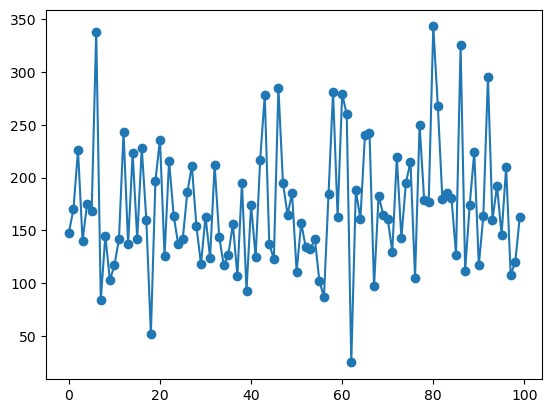

In [19]:
trainer.plotEpisodeRewards()

[   97 19440   764]


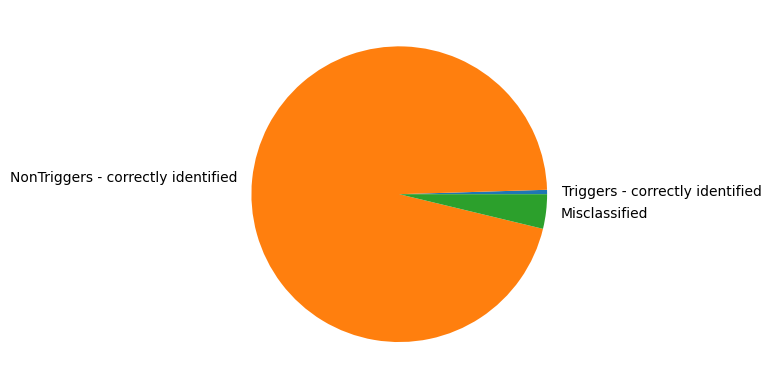

In [20]:
trainer.plotTriggerPieChart()